## Pneumonia Detection Challenge

The goal is to build a pneumonia detection system, to locate the position of inflammation in an image.


In [84]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as pyd
import pydicom
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
import glob 

In [85]:
base_dir = os.getcwd()
data_dir = os.getcwd()+'/input'
working_dir = os.getcwd()+'/working'

In [86]:
images_path = 'input/stage_2_train_images'
train_labels_df = pd.read_csv('input/stage_2_train_labels.csv')
label_meta_data = pd.read_csv('input/stage_2_detailed_class_info.csv')

In [87]:
train_labels_df.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [88]:
label_meta_data.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [89]:
print('Size of Dataset 1: ',train_labels_df.shape)
print('Size of Dataset 2: ',label_meta_data.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels_df['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',label_meta_data['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (30227, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


In [90]:
train_labels_df.drop_duplicates(inplace=True)
label_meta_data.drop_duplicates(inplace=True)
print('Size of Dataset 1: ',train_labels_df.shape)
print('Size of Dataset 2: ',label_meta_data.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels_df['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',label_meta_data['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (26684, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, Age: 51, Sex: F


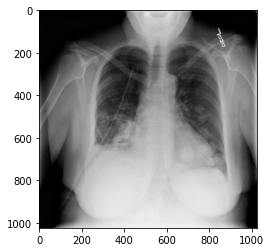

Patient ID: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd, Age: 48, Sex: F


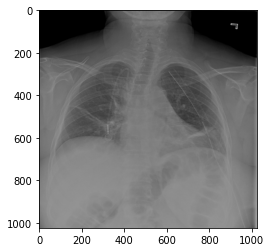

Patient ID: 00322d4d-1c29-4943-afc9-b6754be640eb, Age: 19, Sex: M


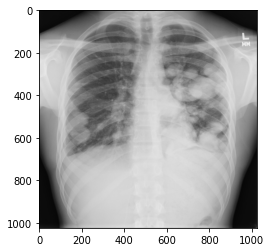

In [91]:
## read some of the dcm files
ctr = 0
for id in label_meta_data['patientId']:
    ds = pyd.dcmread(os.path.join(images_path, id+'.dcm'))
    print('Patient ID: {}, Age: {}, Sex: {}'.format(id, ds.PatientAge, ds.PatientSex))
    plt.imshow(cv2.cvtColor(ds.pixel_array, cv2.COLOR_BGR2RGB))
    plt.show()
    ctr +=1
    if ctr == 3:
        break
    

In [92]:
patient_info_df = pd.DataFrame(columns=['patientId', 'age','sex'])
ctr = 0;
for id in label_meta_data['patientId']:
    ds = pyd.dcmread(os.path.join(images_path, id+'.dcm'))
    patient_info_df.loc[ctr] = [id, ds.PatientAge, ds.PatientSex]
    ctr +=1

In [93]:
display(patient_info_df)

,patientId,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,32,F
...,...,...,...
26679,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,47,F
26680,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,54,M
26681,c1edf42b-5958-47ff-a1e7-4f23d99583ba,46,F
26682,c1f6b555-2eb1-4231-98f6-50a963976431,45,M


In [94]:
# Merging this patient information with the exiting meta data
patient_info_df = pd.merge(label_meta_data,patient_info_df,on="patientId")
patient_info_df

,patientId,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32,F
...,...,...,...,...
26679,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity,47,F
26680,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,54,M
26681,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,46,F
26682,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,45,M


In [95]:
merged_data_info = pd.merge(train_labels_df,patient_info_df,on="patientId")
merged_data_info.head(10)

,patientId,x,y,width,height,Target,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,32,F
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,54,M
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,78,M
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,75,M
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,75,M


In [96]:
merged_data_info.shape

(30227, 9)

In [97]:
print(merged_data_info.shape)
print(merged_data_info.isna().sum())

(30227, 9)
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
age              0
sex              0
dtype: int64


In [98]:
print('Minimum Age in the dataset:', merged_data_info['age'].min())
print('Maximum Age in the dataset', merged_data_info['age'].max())

merged_data_info.columns = merged_data_info.columns.str.strip()
merged_data_info['sex']=merged_data_info['sex'].replace({ 'M' : 0, 'F' : 1  })
merged_data_info['label']=merged_data_info['class']
merged_data_info['label']=merged_data_info['label'].replace({ 'Normal' : 0, 'Lung Opacity' : 1, 'No Lung Opacity / Not Normal' : 2 })



Minimum Age in the dataset: 1
Maximum Age in the dataset 92


In [99]:
merged_data_info['age'] = merged_data_info['age'].astype('int64')

In [100]:
merged_data_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   age        30227 non-null  int64  
 8   sex        30227 non-null  int64  
 9   label      30227 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 2.5+ MB


## Target Distribution

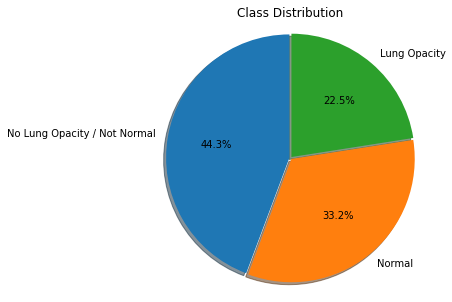

In [101]:
label_count=label_meta_data['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [102]:
merged_data_info.head()

,patientId,x,y,width,height,Target,class,age,sex,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,1,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,1,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,0,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,1,1


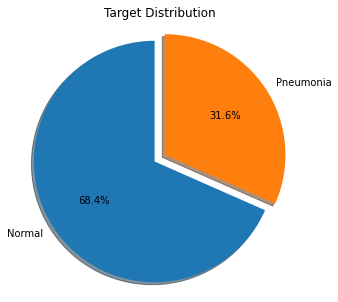

In [103]:
# lets take a look at our Target Distribution
label_count=merged_data_info['Target'].value_counts()
explode = (0.1,0.0)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=['Normal','Pneumonia'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

### Visualization of the Images

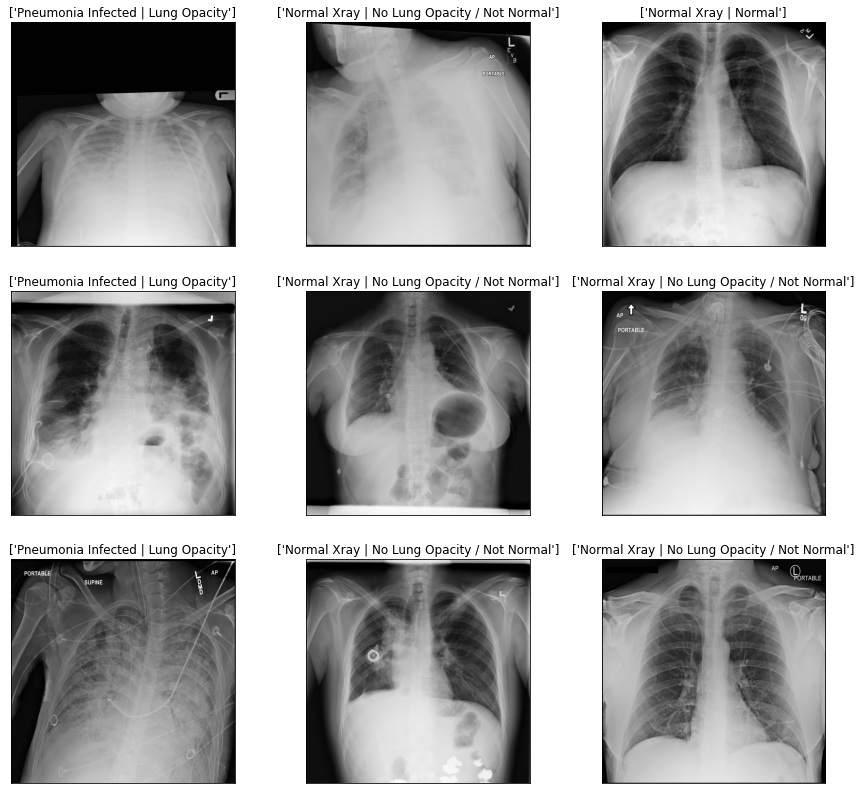

In [104]:
r=c=3
fig= plt.figure(figsize=(15,14))
for i in range(1,r*c+1):
    id_= np.random.choice(merged_data_info['patientId'].values)
    label_0= np.unique(merged_data_info['Target'][merged_data_info['patientId']==id_])
    label_1= np.unique(merged_data_info['class'][merged_data_info['patientId']==id_])
    
    #read xray
    img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
    fig.add_subplot(r,c,i)
    plt.imshow(img,cmap='gray')
    if label_0==1:
        plt.title('Pneumonia Infected'+' | '+label_1)
    else:
        plt.title('Normal Xray'+' | '+label_1)
    plt.xticks([])
    plt.yticks([])

### Visualization of the areas of inflammation

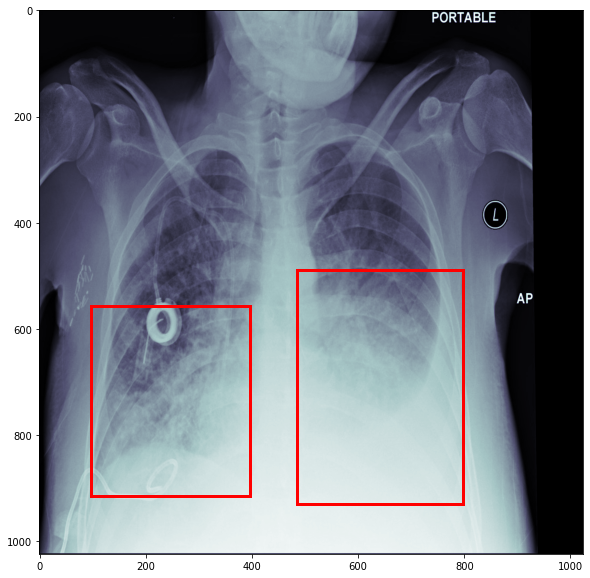

In [105]:
id_= np.random.choice(merged_data_info[merged_data_info['Target'] == 1]['patientId'].values)
class_=merged_data_info['class'][merged_data_info['patientId']==id_]

plt.figure(figsize=(15,10))
current_axis = plt.gca()
img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
plt.imshow(img, cmap='bone')


current_axis = plt.gca()
boxes=train_labels_df[['x','y','width','height']][merged_data_info['patientId']==id_].values

for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    current_axis.add_patch(plt.Rectangle((x, y), w, h, 
                                         color='red', fill=False, linewidth=3))

<AxesSubplot:xlabel='Target', ylabel='count'>

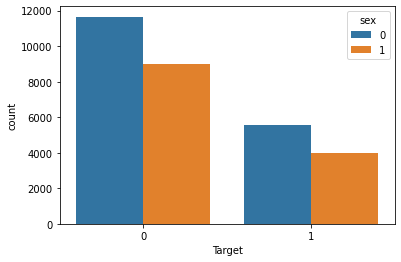

In [106]:
sns.countplot(x=merged_data_info['Target'], hue=merged_data_info['sex'])

## Model

In [107]:
# !git clone git@github.com:akTwelve/Mask_RCNN.git

In [122]:
import sys
sys.path.append(os.path.join(base_dir, 'Mask_RCNN'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [123]:
train_dicom_dir = os.path.join(data_dir, 'stage_2_train_images')
test_dicom_dir = os.path.join(data_dir, 'stage_2_test_images')

In [124]:
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [125]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [146]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 100
    workers=1
    use_multiprocessing=False

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [147]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pyd.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [148]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=working_dir)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [139]:
NUM_EPOCHS = 2
LEARNING_RATE = 0.006

# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [140]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=train_labels_df)

In [141]:
# split dataset into training vs. validation dataset 
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25184 1500


In [142]:
#prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [143]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    7c919028-8325-42d6-8d89-c88595251616
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 12159, dtype: object]

In [144]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [149]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /Users/deeptibaghel/git/gl/projects/12.capstone/working/pneumonia20211023T1553/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (Tim

Exception in thread Thread-31:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/utils/data_utils.py", line 742, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/utils/data_u

KeyboardInterrupt: 

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=working_dir)

# Load trained weights (fill in path to trained weights here)
model_path = 
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])